<a href="https://colab.research.google.com/github/ccc-frankfurt/Practical_ML_SS21/blob/main/week03/MLP_Numpy_FashionMNIST_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of fashion items in images

Zalando research has open-sourced a dataset for classification of 10 different categories of fashion items: https://github.com/zalandoresearch/fashion-mnist

The dataset is referred to as "Fashion-MNIST" as a reference to the much older but still very popular MNIST dataset. The rationale behind this reference is that the dataset has similar properties. It can thus be used in the exact same manner as MNIST has been used for years of research.

Specifically, we are dealing with 28x28 grayscale images from the following classes:

    0 T-shirt/top
    1 Trouser
    2 Pullover
    3 Dress
    4 Coat
    5 Sandal
    6 Shirt
    7 Sneaker
    8 Bag
    9 Ankle boot

In comparison to the traditional handwritten-digit recognition shown in MNIST, this dataset is slightly harder (it is very easy to achieve more than 99% accuracy on MNIST with only subtleties in performance based on methodology). On Fashion-MNIST we will see a much bigger difference when moving from e.g. a MLP to a deep CNN later.

## MLP from scratch - using Numpy only
In order to learn more about neural networks we will start with an example of a 1 (or if you want 2) hidden layer Multilayer Perceptron (MLP) from scratch implemented with Numpy only. While there is many novel libraries that abstract away all the math and algorithms, it is a good practice to go through the basics in detail once before moving on to the more complex CNN or RNN examples.

### Getting the data
By now you should have a fair grasp of how to write a data-loader so we are not going to implement a data-loader from scratch again. The official repository for Fashion-MNIST already has instructions of how to load the data. However it's sort of inconvenient given that you have to download files by hand, unpack them, call their API etc.

In general, what frameworks such as TensorFlow and PyTorch will later do for us is write a dataset class that offers all the necessary functionality for us. This usually includes automatical downloads (and checks to not download if the data is already existent), offer functions to get training and validation splits, possibly transformations or datatype options, or even a complete data-loader including suitable iterators.

We have given a minimal example of what such a data-loader could look like below. For now, you should examine it and try to understand the individual components. When we move to the next session where we will implement a CNN with a modern Deep Learning framework such as PyTorch, we will see how easily we could extend this data-loader to be included there. Of course the PyTorch developers have already done that for us, but we will go through the practice nevertheless. This way you can learn how to contribute to modern Deep Learning software and potentially even do a pull-request of your own dataset or some other non-wrapped dataset at some point in time.

### Dataset class

In [1]:
import os
import struct
import gzip
import errno
import numpy as np

class FashionMNIST:
    """
    Fashion MNIST dataset featuring gray-scale 28x28 images of
    fashion items belonging to ten different classes.
    Dataloader adapted from MNIST.
    We do not define __getitem__ and __len__ in this class
    as we are using torch.utils.data.TensorDataSet which
    already implements these methods.

    Attributes:
        train_x (np.array): Training set images.
        train_y (np.array): Training set labels.
        val_x (np.array): Validation set images.
        val_y (np.array): Validation set labels.
        
    """

    def __init__(self):
        self.path = os.path.expanduser('datasets/FashionMNIST')
        self.__download()

        self.train_x, self.train_y, self.val_x, self.val_y = self.get_dataset()

        self.class_to_idx = {'T-shirt/top': 0,
                        'Trouser': 1,
                        'Pullover': 2,
                        'Dress': 3,
                        'Coat': 4,
                        'Sandal': 5,
                        'Shirt': 6,
                        'Sneaker': 7,
                        'Bag': 8,
                        'Ankle boot': 9}

    def __check_exists(self):
        """
        Checks if dataset has already been downloaded

        Returns:
             bool: True if downloaded dataset has been found
        """

        return os.path.exists(os.path.join(self.path, 'train-images-idx3-ubyte.gz')) and \
               os.path.exists(os.path.join(self.path, 'train-labels-idx1-ubyte.gz')) and \
               os.path.exists(os.path.join(self.path, 't10k-images-idx3-ubyte.gz')) and \
               os.path.exists(os.path.join(self.path, 't10k-labels-idx1-ubyte.gz'))

    def __download(self):
        """
        Downloads the Fashion-MNIST dataset from the web if dataset
        hasn't already been downloaded.
        """

        from six.moves import urllib

        if self.__check_exists():
            return

        print("Downloading FashionMNIST dataset")
        urls = [
            'https://cdn.rawgit.com/zalandoresearch/fashion-mnist/ed8e4f3b/data/fashion/train-images-idx3-ubyte.gz',
            'https://cdn.rawgit.com/zalandoresearch/fashion-mnist/ed8e4f3b/data/fashion/train-labels-idx1-ubyte.gz',
            'https://cdn.rawgit.com/zalandoresearch/fashion-mnist/ed8e4f3b/data/fashion/t10k-images-idx3-ubyte.gz',
            'https://cdn.rawgit.com/zalandoresearch/fashion-mnist/ed8e4f3b/data/fashion/t10k-labels-idx1-ubyte.gz',
        ]

        # download files
        try:
            os.makedirs(self.path)
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise

        for url in urls:
            print('Downloading ' + url)
            data = urllib.request.urlopen(url)
            filename = url.rpartition('/')[2]
            file_path = os.path.join(self.path, filename)
            with open(file_path, 'wb') as f:
                f.write(data.read())

        print('Done!')

    def __get_fashion_mnist(self, path, kind='train'):
        """
        Load Fashion-MNIST data

        Parameters:
            path (str): Base directory path containing .gz files for
                the Fashion-MNIST dataset
            kind (str): Accepted types are 'train' and 't10k' for
                training and validation set stored in .gz files

        Returns:
            numpy.array: images, labels
        """

        labels_path = os.path.join(path,
                                   '%s-labels-idx1-ubyte.gz'
                                   % kind)
        images_path = os.path.join(path,
                                   '%s-images-idx3-ubyte.gz'
                                   % kind)

        with gzip.open(labels_path, 'rb') as lbpath:
            struct.unpack('>II', lbpath.read(8))
            labels = np.frombuffer(lbpath.read(), dtype=np.uint8)

        with gzip.open(images_path, 'rb') as imgpath:
            struct.unpack(">IIII", imgpath.read(16))
            images = np.frombuffer(imgpath.read(), dtype=np.uint8).reshape(len(labels), 784)

        return images, labels


    def get_dataset(self):
        """
        Loads and wraps training and validation datasets

        Returns:
             np.array: x_train, y_train, x_val, y_val
        """

        x_train, y_train = self.__get_fashion_mnist(self.path, kind='train')
        x_val, y_val = self.__get_fashion_mnist(self.path, kind='t10k')

        return x_train, y_train, x_val, y_val

In [2]:
Dataset = FashionMNIST()
print(Dataset.train_x.shape, Dataset.train_y.shape, Dataset.val_x.shape, Dataset.val_y.shape)

# normalize the uint8 images to a float 0-1 range. 
# This is necessary so that the Sigmoid function does not saturate and the gradient doesn't vanish
Dataset.train_x = Dataset.train_x / 255.
Dataset.val_x = Dataset.val_x / 255.

Done!
(60000, 784) (60000,) (10000, 784) (10000,)


## Setting up a Neural Network with hidden layers: the multi-layer perceptron (MLP)
We will take a look at a MLP where every unit of one layer is connected to every unit of the next with multiple hidden layers.

If we recall a logistic regression, then this could be interpreted as just a perceptron, i.e. a very simple one layer neural network that maps the input through an activation function to the output. In MLPs each layer consist of such a building block.

Let us therefore first define the rectified linear unit (ReLU) activation function and the Sigmoid function necessary to obtain the output probability and their respective derivatives required for backpropagation.

* Sigmoid: S(x) = $\frac{1}{1 + \exp(-x)}$
* ReLU: $max(0, x)$

For the derivative of the Sigmoid function we can use a trick by adding and subtracting from the derivative obtained by the quotient rule. This way we can obtain the derivative in a much more simple form: $S(x) * (1 - S(x))$

We recommend to go through the respective derivation that is nicely detailed in e.g. this blog post: https://beckernick.github.io/sigmoid-derivative-neural-network/

In [3]:
# sigmoid function
def sigmoid(x, deriv=False):
    # define the derivative
    if(deriv==True):
        return sigmoid(x, deriv=False) * (1 - sigmoid(x, deriv=False))
    return 1 / (1 + np.exp(-x))

# activation function: here a ReLU
def ReLU(x, deriv=False):
    # define the derivative
    if (deriv == True):
        relu_grad = x > 0
        return x * relu_grad
    else:
        return np.maximum(0, x)

### Optimization with gradient descent
Similarly to what we have already learned in logistic regression, we will run mini-batch stochastic gradient descent, i.e. an update step requires a subset of the dataset, in order to optimize the weights of our neural network.

Again we can decide whether we want to train in a regression fashion or using a likelihood approach such as with the cross entropy loss. In any way we will need to change our labels from a single integer, to a one-hot-vector where an index 1 is at the position of the correct answer. In our example this will be a vector of length 10, with all zeros and exactly one one. The error can then be computed between the length 10 label/target vector and the 10 output neurons of our model. In this very simple example we will just use the mean squared error between the two.

It is recommended to use the weight initialization scheme derived by He. et. al in "Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification" https://arxiv.org/abs/1502.01852 for rectified linear units:

* $W \sim \mathcal{N}(0, \sqrt{\frac{2}{\mathtt{number \, of \, layer \, units}}})$


In [4]:
activation = ReLU

# seed random numbers for reproducibility
np.random.seed(10)

# get the total amount of classes
n_classes = np.max(Dataset.train_y) + 1

# set amount of hidden units for the two hidden layers. A good starting value is 100
h1_units = 100
h2_units = 100


# Initialize the sets of weights for each layer
W0 = np.random.normal(loc=0.0, 
                      scale = np.sqrt(2/(Dataset.train_x.shape[1]+h1_units)), 
                      size = (Dataset.train_x.shape[1], h1_units))
W1 = np.random.normal(loc=0.0, 
                      scale = np.sqrt(2/(W0.shape[1]+h2_units)), 
                      size = (W0.shape[1], h2_units))
W2 = np.random.normal(loc=0.0, 
                      scale = np.sqrt(2/(W1.shape[1]+n_classes)), 
                      size = (W1.shape[1], n_classes))

# Create a one-hot target encoding
# empty one-hot matrix
y = np.zeros((Dataset.train_y.shape[0], n_classes))

# set target idx to 1
y[np.arange(Dataset.train_y.shape[0]), Dataset.train_y] = 1.

# choose a batch size and learning rate. Good initial values are a 
# mini-batch size of 100 and a small learning rate of 10e-3
mb_size = 100
lr = 0.001

epochs = 20
# optimize
for epoch in range(epochs):
    
    # shuffle the dataset
    perm = np.random.permutation(len(Dataset.train_x))
    x_train, y_train = Dataset.train_x[perm], y[perm]
    
    # because we are shuffling the dataset at every point and we do not want
    # updates on a tiny batch size we can neglect the last mini-batch that is 
    # smaller than our mini-batch nice. 
    for mb in range(int(len(x_train) / mb_size)):
        inp = x_train[mb*mb_size:(mb+1)*mb_size]
        target = y_train[mb*mb_size:(mb+1)*mb_size]
    
        # forward propagation
        h1 = activation(inp @ W0)
        h2 = activation(h1 @ W1)
        prediction = sigmoid(h2 @ W2)

        # compute the loss
        loss = np.mean((prediction - target)**2)

        # multiply how much we missed by the 
        # slope of the sigmoid at the values in the ultimate layer
        loss_delta = 2*(prediction - target) * sigmoid(prediction, True)

        # backpropagate above quantity for the second layer error
        h2_delta = (loss_delta @ W2.T) * activation(h2, True)

        # backpropagate above wuantity for the first layer error
        h1_delta = (h2_delta @ W1.T) * activation(h1, True)

        # update weights
        W2 += -lr * (h2.T @ loss_delta) / inp.shape[0]
        W1 += -lr * (h1.T @ h2_delta) / inp.shape[0]
        W0 += -lr * (inp.T @ h1_delta) / inp.shape[0]

    print("Error:" + str(loss))

Error:0.09700192579017687
Error:0.08253554217693294
Error:0.046301766412940114
Error:0.04446887911224539
Error:0.048470092578837526
Error:0.0381001960704525
Error:0.04187523554369875
Error:0.02996532687972696
Error:0.030406230658175357
Error:0.031334884412198664
Error:0.022684602460221588
Error:0.029968680566228457
Error:0.030497036186119857
Error:0.03055260540723196
Error:0.02414529108822573
Error:0.029710530595037227
Error:0.028494960551483903
Error:0.028141070292944947
Error:0.03628236283200423
Error:0.024372773400778817


### Accuracy
Let's again write a function to calculate the models accuracy on the classification task and evaluate it for train and validation sets.

In [5]:
def eval_acc(x, y):
    acc = 0.0
    
    # forward propagation
    h1 = activation(x @ W0)
    h2 = activation(h1 @ W1)
    prediction = sigmoid(h2 @ W2)

    # get the most likely class index of the prediction
    predicted_label = np.argmax(prediction, axis=-1)
    
    acc = np.sum(predicted_label == y) / len(x)
            
    return acc

In [6]:
train_acc = eval_acc(Dataset.train_x, Dataset.train_y)
val_acc = eval_acc(Dataset.val_x, Dataset.val_y)

print("Training accuracy: ", train_acc)    
print("Validation accuracy: ", val_acc)  

Training accuracy:  0.8077833333333333
Validation accuracy:  0.8114


Even with a simple MLP we can achieve accuracies greater than 80%. For reference: 10% is the chance if one were to random guess. We will later see that more advanced neural networks that can better take into account spatial information, such as Convolutional Neural Networks (CNN) will do even much better than that. 

You can check how well you are doing on FashionMNIST by checking the online leaderboard: http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/

### Monitoring and confusion matrices

Instead of simply looking at the overall accuracy, we could monitor a confusion matrix. In a confusion matrix both axes of the matrix represent the classes of the classification task and each row describes the class that our neural network predicted for each given label.  Using this information we can determine which class is particularly difficult or easy, which class often gets predicted as false positive or which ones get missed. 

In [7]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def calculate_confusion(x, y):
    h1 = activation(x @ W0)
    h2 = activation(h1 @ W1)
    prediction = sigmoid(h2 @ W2)
    
    predicted_label = np.argmax(prediction, axis=-1)

    confusion = confusion_matrix(y, predicted_label)
    
    # normalize
    confusion = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
    
    return confusion

def visualize_confusion(matrix, class_dict):
    """
    Visualization of confusion matrix

    Parameters:
        matrix (numpy.array): Square-shaped array of size class x class.
            Should specify cross-class accuracies/confusion in percent
            values (range 0-1).
        class_dict (dict): Dictionary specifying class names as keys and
            corresponding integer labels/targets as values.
    """

    all_categories = sorted(class_dict, key=class_dict.get)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax,
                 boundaries=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

    # Set up axes
    ax.set_xticklabels([''] + all_categories, rotation=90)
    ax.set_yticklabels([''] + all_categories)

    plt.show()

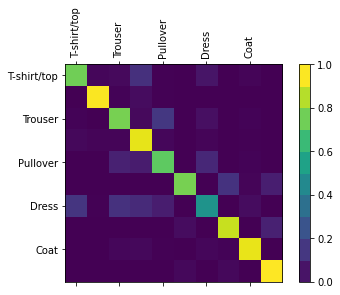

In [8]:
conf = calculate_confusion(Dataset.val_x, Dataset.val_y)
visualize_confusion(conf, Dataset.class_to_idx)

## Extending what we have

* 1.) The used error metric is linear and thus makes it harder to learn for the model when high accuracies are reached (because error and output values are very close and lead to small gradients). Implement a Cross-entropy criterion based on the log-softmax function followed by the negative log-likelihood instead. Why is this a better choice for a multi-class classification problem? 
* 2.) The above example only used the training set and monitored the training error. This is generally a bad idea because we have no notion of over-fitting. Use the given validation set to monitor your error and decide a suitable stopping point. 
